In [2]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline


#import seaborn as sns
#sns.set(rc={"figure.figsize": (8, 8)})

In [3]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data
cuip = os.getenv('CUIP')
csvs = 'output_csvs'


## Create CSV, First Version

In [66]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import pylab as pl
from skimage import filters
import csv


PLOT = False


def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def getregion(img, threshold):
    """Extract labeled objects from images and create new features using the output.
    Input 2D array (image), resize it using rebin and threshold filter it
    using the default threshold: Mean + 3*Std
    
    The output are five numbers
    """
    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    if threshold == 'm3sd':
        imgtmp[tmp2<np.mean(tmp2) + 3.*np.std(tmp2)]=0
    elif threshold == 'm4sd':
        imgtmp[tmp2<np.mean(tmp2) + 4.*np.std(tmp2)]=0
        
    else:
        raise ValueError, 'Please specify a valid threshold'
    
    imgtmp[imgtmp>0]=1
    
    labels, n_features = ndimage.measurements.label(imgtmp)
    
    labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])
    lbl_names = np.unique(labels)
    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
   
    mean_x = np.zeros(len(lbl_names[1:]))
    mean_y = np.zeros(len(lbl_names[1:]))    
    sdx = np.zeros(len(lbl_names[1:]))
    sdy = np.zeros(len(lbl_names[1:]))
    
    for i,j in enumerate(lbl_names[1:]):
        x,y = np.where(labels == j)
        #print i,len(x),len(y)
        
        mean_x[i] = x.mean()
        mean_y[i] = y.mean()
        sdx[i] = x.std()
        sdy[i] = y.std()
    
    
    top_idx = sorted(range(len(labelsize[1:])), key=lambda i: labelsize[1:][i], reverse=True)[:2]
    
    mx1,mx2 = mean_x[top_idx[0]],mean_x[top_idx[1]]
    my1,my2 = mean_y[top_idx[0]],mean_y[top_idx[1]]
    sdx1,sdx2 = sdx[top_idx[0]], sdx[top_idx[1]]
    sdy1,sdy2 = sdy[top_idx[0]], sdy[top_idx[1]]
   

    return(len(labs),np.max(labdiff[:-1]),(labdiff>=50).sum(),n_features,
           np.mean(labdiff[:-1]),
           sdx1,sdy1,sdx2,sdy2,mx1,my1,mx2,my2)


def create_csv(ifile_path, ofile_path, threshold):
    tmp = np.sort(glob.glob(ifile_path))
    csvfile = open(ofile_path,'w')
    col_names = ['image', 'n_patches','largest_patch','patch_50+_pix',
                 'n_features','mean_patch_size','sdx_largest',
                 'sdy_largest','sdx_2nd_largest','sdy_2nd_largest',
                'center_X_largest','center_Y_largest','center_X_2largest','center_Y_2largest']
    
    writer = csv.writer(csvfile, delimiter=',',lineterminator='\n')
    writer.writerow(col_names)
    for t in tmp:
        try:
            img = np.load(t)[200:1300,:,:].mean(-1)
        except:
            pass
        line = [t[68:]]
        line.extend(getregion(img, threshold))  
        writer.writerow(line)
    #csvfile.close()
    
#if __name__ == '__main__':
#    plot = PLOT
#    plumes = os.getenv('PLUMES')
#    imgpath = os.path.join(plumes,'outputs/tmp_0*_mindif.npy')

#    create_csv(imgpath,'output_csvs/mean+4sd_mindif.csv', threshold = 'm4sd')


## Create CSV, Second Version

In [ ]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import os
import glob
import numpy as np
import csv


PLOT = False

def getregion(img, threshold):
    """Extract labeled objects from images and create new features using the output.
    Input 2D array (image), resize it using rebin and threshold filter it
    using the default threshold: Mean + 3*Std
    
    The output are five numbers
    """
    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    if threshold == 'm3sd':
        imgtmp[tmp2<np.mean(tmp2) + 3.*np.std(tmp2)]=0
    elif threshold == 'm4sd':
        imgtmp[tmp2<np.mean(tmp2) + 4.*np.std(tmp2)]=0
        
    else:
        raise ValueError, 'Please specify a valid threshold'
    
    imgtmp[imgtmp>0]=1
    
    labels, nlbl = ndimage.measurements.label(imgtmp)
    lbl_names = np.arange(1, nlbl+1)
    
    labelsize = ndimage.measurements.sum(imgtmp, labels, index = lbl_names)


    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
    
    centroid = ndimage.measurements.center_of_mass(imgtmp, labels, index = lbl_names)

    cent_x = np.zeros(len(centroid))
    cent_y = np.zeros(len(centroid))

    for i in range(len(centroid)):
        cent_x[i] = centroid[i][0]
        cent_y[i] = centroid[i][1]
   

    return(len(labs), np.max(labelsize), (labelsize>=50).sum(), nlbl,
           labelsize.mean(), labelsize.std(), cent_x.mean(), cent_y.mean(), cent_x.std(), cent_y.std())


def create_csv(ifile_path, ofile_path, threshold):
    tmp = np.sort(glob.glob(ifile_path))
    csvfile = open(ofile_path,'w')
    col_names = ['image', 'n_patches','largest_patch','patch_50+_pix',
                 'n_features','mean_patch_size', 'std_patch_size', 'mean_cent_X', 'mean_cent_Y']
    
    writer = csv.writer(csvfile, delimiter=',',lineterminator='\n')
    writer.writerow(col_names)
    for t in tmp:
        try:
            img = np.load(t)[200:1300,:,:].mean(-1)
        except:
            pass
        line = [t[68:]]
        line.extend(getregion(img, threshold))  
        writer.writerow(line)
    #csvfile.close()
    
if __name__ == '__main__':
    plot = PLOT
    plumes = os.getenv('PLUMES_DATA')
    imgpath = os.path.join(plumes,'outputs/tmp_0*_median.npy')

    create_csv(imgpath,'output_csvs/mean+3sd_median_2.csv', threshold = 'm3sd')


# Load the images

Load a smaller set of images to try out calculations before going to script writing.

In [168]:

#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')
#print imgpath
#imglist2 = sorted(glob.glob(imgpath2))        
#print imglist
#empty array to catch read images

#imgs_min = np.zeros((nimgs, 1300, 4096))
#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)

imgpath1 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_median.npy')
imglist1 = sorted(glob.glob(imgpath1))
nimgs = len(imglist1)
imgs = np.zeros((nimgs, 1100, 4096))    
for i,f in enumerate(imglist1):
    
    imgs[i] = np.load(f)[200:1300,:,:].mean(-1)
    #writer.writerow([f[68:], getregion(imgs[i])])
    

## The file is loaded here.

A new feature is created, the one you proposed.

In [287]:
df = pd.read_csv('output_csvs/mean+3sd_median.csv', header = 0)
#idx = [i for i in range(5, df.shape[0] + 5)]
df.index = df.index + 5
#df.index.name = 'image'
#del df['image']

df['feat*pix50'] = df['n_features'] * df['patch_50+_pix']
df['mean*nps'] = df['mean_patch_size'] * df['n_patches']
df['mean*feat'] = df['mean_patch_size'] * df['n_features']
df['radius_1'] = np.sqrt(df.sdx_largest**2 + df.sdy_largest**2)
df['radius_2'] = np.sqrt(df.sdx_2nd_largest**2 + df.sdy_2nd_largest**2)
df['centroid_distance'] = np.sqrt((df.center_X_largest - df.center_X_2largest)**2 
                                  + (df.center_Y_largest - df.center_Y_2largest)**2)
#df['radius_ratios'] = df.radius_2 / df.radius_1

displ_x = np.diff(df.center_X_largest)
displ_x = np.insert(displ_x,0,0)
df['centroid_displ_X'] = displ_x

displ_y = np.diff(df.center_Y_largest)
displ_y = np.insert(displ_y,0,0)
df['centroid_displ_Y'] = displ_y

df['total_displacement'] = np.sqrt((df.center_X_largest-df.centroid_displ_X)**2 
                                   + (df.center_X_largest-df.centroid_displ_Y)**2)




In [286]:
df2 = pd.read_csv('output_csvs/mean+4sd_median.csv', header = 0)
#idx = [i for i in range(5,df2.shape[0] + 5)]
df2.index = df2.index + 5
#df2.index.name = 'image'
#df2.index = df['#image']
#del df2['#image']

df2['feat*pix50'] = df2['n_features'] * df2['patch_50+_pix']
df2['mean*nps'] = df2['mean_patch_size'] * df2['n_patches']
df2['mean*feat'] = df2['mean_patch_size'] * df2['n_features']
df2['radius_1'] = np.sqrt(df2.sdx_largest**2 + df2.sdy_largest**2)
df2['radius_2'] = np.sqrt(df2.sdx_2nd_largest**2 + df2.sdy_2nd_largest**2)
df2['centroid_distance'] = np.sqrt((df2.center_X_largest - df2.center_X_2largest)**2 
                                   + (df2.center_Y_largest - df2.center_Y_2largest)**2)
#df['radius_ratios'] = df.radius_2 / df.radius_1

displ_x = np.diff(df2.center_X_largest)
displ_x = np.insert(displ_x,0,0)
df2['centroid_displ_X'] = displ_x

displ_y = np.diff(df2.center_Y_largest)
displ_y = np.insert(displ_y,0,0)
df2['centroid_displ_Y'] = displ_y

df2['total_displacement'] = np.sqrt((df2.center_X_largest-df2.centroid_displ_X)**2 
                                   + (df2.center_X_largest-df2.centroid_displ_Y)**2)


df2.head()

,image,n_patches,largest_patch,patch_50+_pix,n_features,mean_patch_size,sdx_largest,sdy_largest,sdx_2nd_largest,sdy_2nd_largest,...,center_Y_2largest,feat*pix50,mean*nps,mean*feat,radius_1,radius_2,centroid_distance,centroid_displ_X,centroid_displ_Y,total_displacement
5,outputs/tmp_0005_median.npy,21,4,1,769,1.315789,0.923077,3.613748,1.991718,1.774475,...,155.818182,769,27.631579,1011.842105,3.729778,2.667527,132.271393,0.000000,0.000000,294.700349
6,outputs/tmp_0006_median.npy,11,7,1,628,1.777778,1.283378,1.191086,0.774597,0.979796,...,75.800000,628,19.555556,1116.444444,1.750927,1.249000,4.128540,-79.384615,55.719457,220.894060
7,outputs/tmp_0007_median.npy,26,11,1,1150,1.750000,5.812930,2.350794,1.739926,1.727534,...,154.875000,1150,45.500000,2012.500000,6.270278,2.451881,79.216827,-5.023256,63.681259,142.395736
8,outputs/tmp_0008_median.npy,13,29,1,588,3.727273,1.565827,3.118593,1.716609,0.828487,...,1.923077,588,48.454545,2191.636364,3.489619,1.906079,363.466825,-44.286268,200.097453,172.823821
9,outputs/tmp_0009_median.npy,15,27,1,705,3.000000,2.030856,1.896708,0.605693,1.902972,...,108.384615,705,45.000000,2115.000000,2.778826,1.997039,125.721118,50.534524,-268.640476,406.748374


## Rolling window pandas

This were the first rolling windows which were not correct, this wa sonly the first attempt.

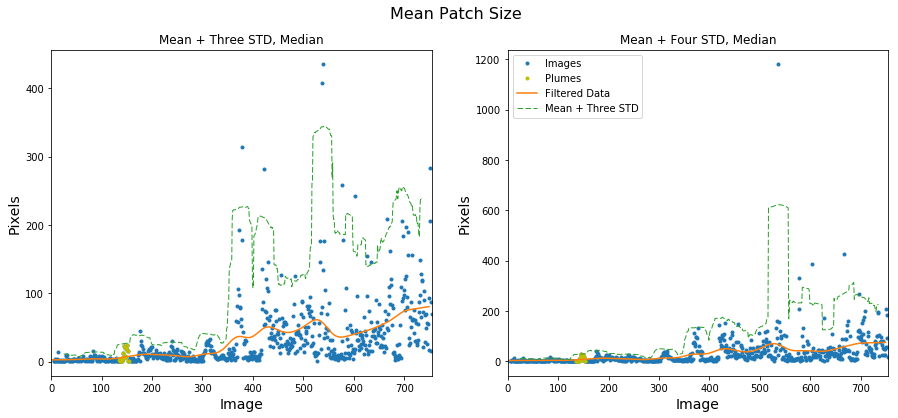

In [147]:
unsmooth = df.mean_patch_size
unsmooth2 = df2.mean_patch_size

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + 3*final.smooth_std   
final['g2+3sd'] = g2 + 3*final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Mean Patch Size', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + Three STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_mean_patchsize.pdf')


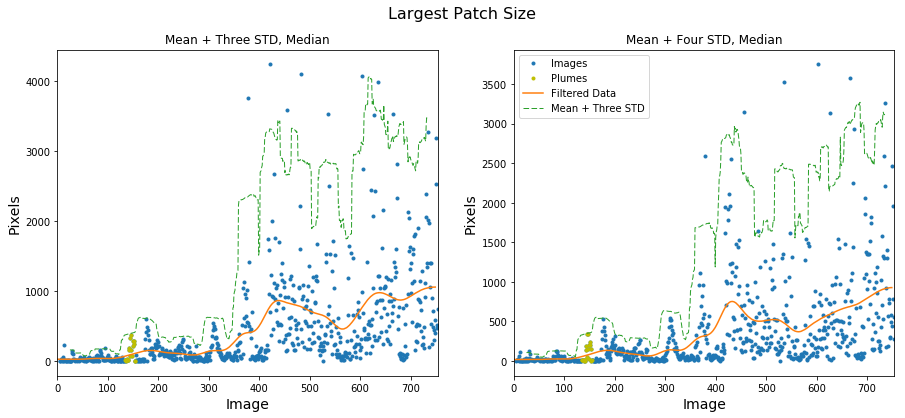

In [148]:
unsmooth = df.largest_patch
unsmooth2 = df2.largest_patch

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + 3*final.smooth_std   
final['g2+3sd'] = g2 + 3*final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Largest Patch Size', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + Three STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_largest_patchsize.pdf')


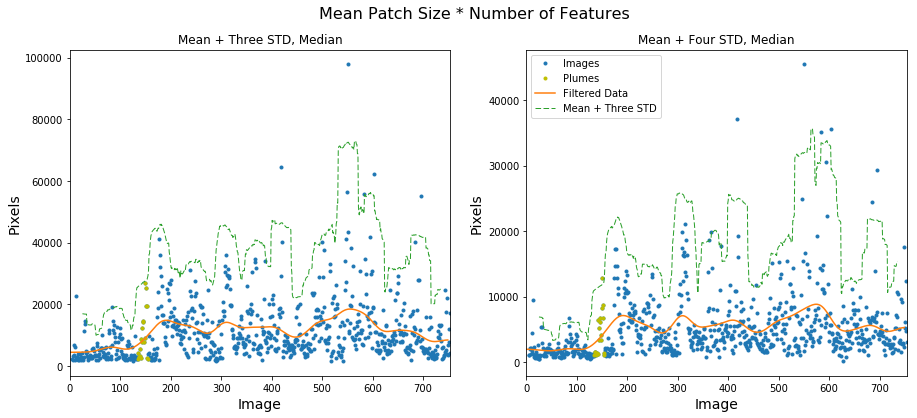

In [149]:
unsmooth = df['mean*feat']
unsmooth2 = df2['mean*feat']

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + 3*final.smooth_std   
final['g2+3sd'] = g2 + 3*final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Mean Patch Size * Number of Features', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + Three STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_mean_nfeat.pdf')


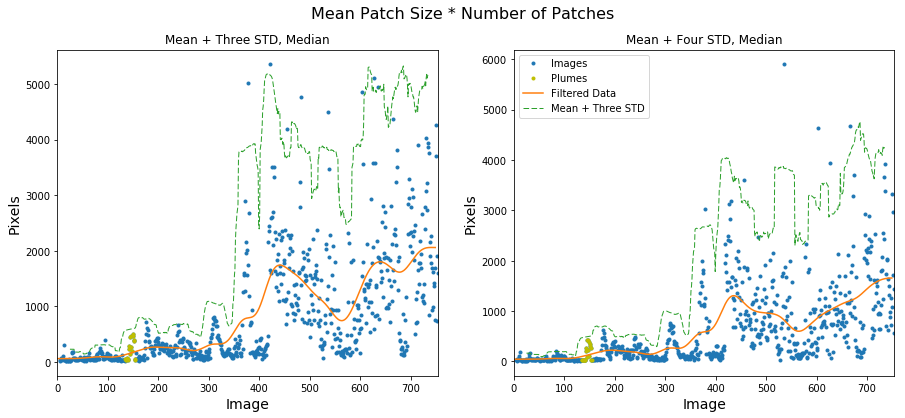

In [150]:
unsmooth = df['mean*nps']
unsmooth2 = df2['mean*nps']

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + 3*final.smooth_std   
final['g2+3sd'] = g2 + 3*final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Mean Patch Size * Number of Patches', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + Three STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_mean_npatches.pdf')


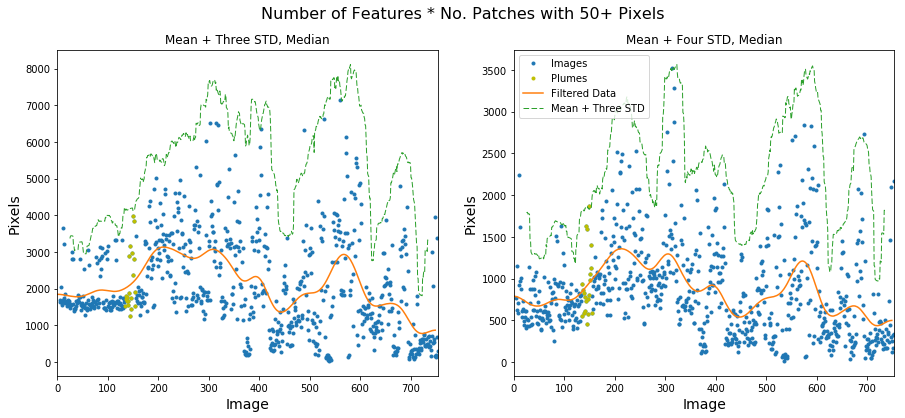

In [151]:
unsmooth = df['feat*pix50']
unsmooth2 = df2['feat*pix50']

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + 3*final.smooth_std   
final['g2+3sd'] = g2 + 3*final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Number of Features * No. Patches with 50+ Pixels', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + Three STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_nfeat_patch50.pdf')


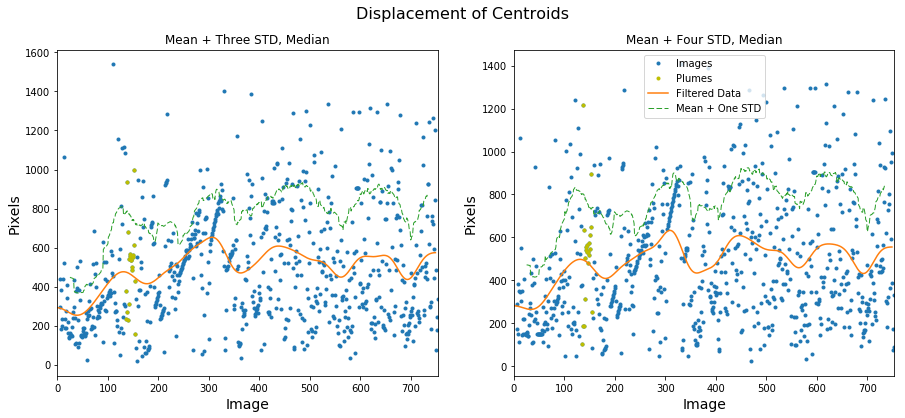

In [152]:
unsmooth = df.total_displacement
unsmooth2 = df2.total_displacement

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + final.smooth_std   
final['g2+3sd'] = g2 + final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Displacement of Centroids', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + One STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_centroid_displacement.pdf')


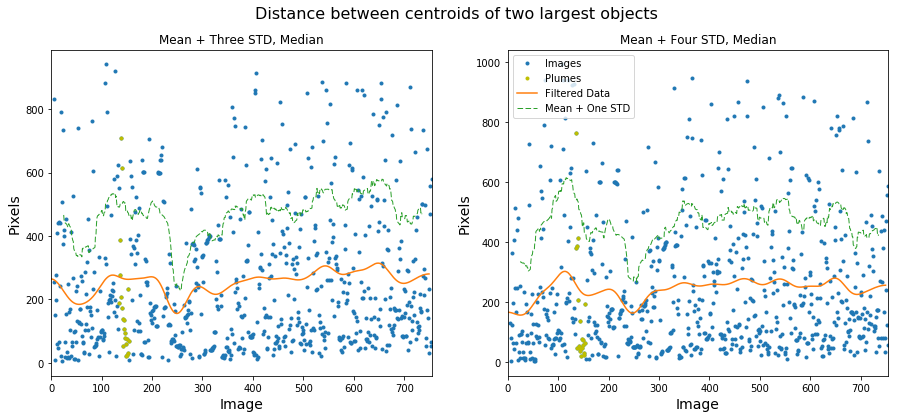

In [298]:
unsmooth = df.centroid_distance
unsmooth2 = df2.centroid_distance

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + final.smooth_std   
final['g2+3sd'] = g2 + final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Distance between centroids of two largest objects', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + One STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_centroid_euclidean.pdf')


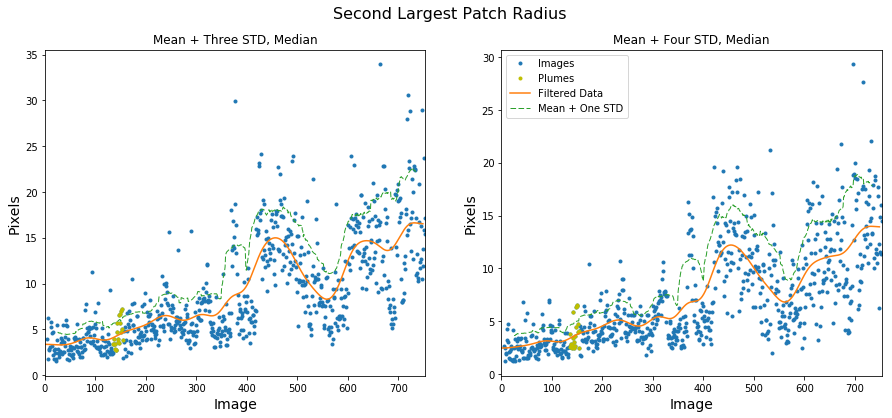

In [155]:
unsmooth = df.radius_2
unsmooth2 = df2.radius_2

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + final.smooth_std   
final['g2+3sd'] = g2 + final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle ='--', linewidth=1)

fig.suptitle('Second Largest Patch Radius', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + One STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Mean + Three STD, Median')
ax2.set_title('Mean + Four STD, Median')
plt.savefig('output_imgs/median_2nd_largest_radius.pdf')


In [334]:
tmp2 = rebin(imgs[15], (imgs[13].shape[0]/4, imgs[13].shape[1]/4))
imgtmp = tmp2.copy()
imgtmp[tmp2<np.mean(tmp2) + 3.*np.std(tmp2)]=0
imgtmp[imgtmp>0]=1

labels, nlbl = ndimage.measurements.label(imgtmp)

lbl_names = np.arange(1, nlbl+1)
labelsize = ndimage.measurements.sum(tmp2, labels, index = lbl_names)


labs = np.unique(labelsize)
labdiff = np.diff(np.unique(labelsize))

centroid = ndimage.measurements.center_of_mass(tmp2, labels, index = lbl_names)

cent_x = np.zeros(len(centroid))
cent_y = np.zeros(len(centroid))


for i in range(len(centroid)):
    cent_x[i] = centroid[i][0]
    cent_y[i] = centroid[i][1]
    
    
cent_x.mean(), cent_y.mean()

(157.77701725680467, 326.81758174293486)

In [329]:
df3 = pd.read_csv('output_csvs/mean+3sd_median_2.csv', header = 0)
df3.head()


#displ_x = np.diff(df3.mean_cent_X)
#displ_x = np.insert(displ_x,0,0)
#df3['centroid_displ_X'] = displ_x

#displ_y = np.diff(df3.mean_cent_Y)
#displ_y = np.insert(displ_y,0,0)
#df3['centroid_displ_Y'] = displ_y

#df3['total_displacement'] = np.sqrt((df3.mean_cent_X-df3.centroid_displ_X)**2 + (df3.mean_cent_Y-df3.centroid_displ_Y)**2)

,image,n_patches,largest_patch,patch_50+_pix,n_features,mean_patch_size,std_patch_size,mean_displ_X,mean_displ_Y,std_displ_X,std_displ_Y
0,outputs/tmp_0005_median.npy,24,31.0,0,1628,2.062039,2.622518,0.168408,0.497849,0.666346,258.418303
1,outputs/tmp_0006_median.npy,16,19.0,0,1678,1.599523,1.539871,0.163387,0.460346,0.628723,291.026153
2,outputs/tmp_0007_median.npy,32,50.0,1,2033,2.606493,3.712172,0.134843,0.389764,1.407403,239.059752
3,outputs/tmp_0008_median.npy,16,63.0,1,1622,1.596794,2.224777,0.169031,0.427514,0.642086,292.179775
4,outputs/tmp_0009_median.npy,26,57.0,1,1539,1.942820,2.820947,0.178153,0.463589,0.687497,270.343262


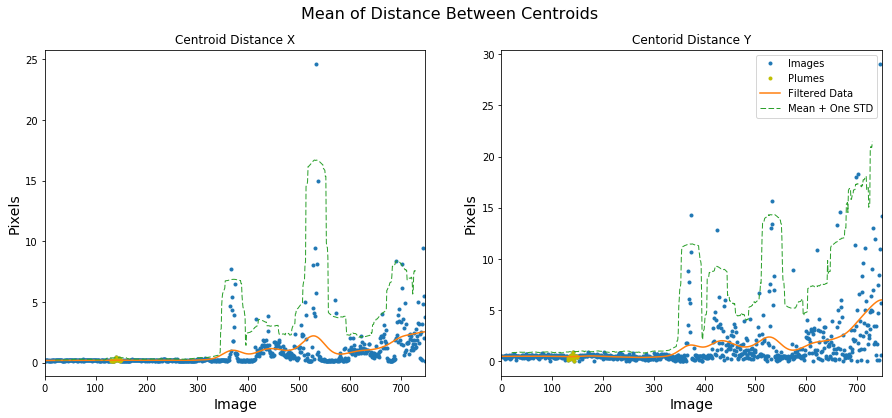

In [332]:
unsmooth = np.abs(df3.mean_displ_X)
unsmooth2 = np.abs(df3.mean_displ_Y)

g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
g2 = ndimage.filters.gaussian_filter(unsmooth2, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
smooth_sd2 = unsmooth2.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'unsmooth2':unsmooth2, 
                      'smooth_std':smooth_sd, 'smooth_std2':smooth_sd2})
final['g+3sd'] = g + 3*final.smooth_std   
final['g2+3sd'] = g2 + 3*final.smooth_std2


fig = plt.figure()


ax1 = fig.add_subplot(121)
ax1 = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax1, marker = '.', linestyle = 'none', c = 'y')
ax1.plot(g)
final['g+3sd'].plot(ax = ax1, linestyle ='--', linewidth=1)

ax2 = fig.add_subplot(122)
ax2 = final.unsmooth2.plot(figsize = (15,6), linestyle = 'none', marker = '.')
final.unsmooth2[130:150].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')
ax2.plot(g2)
final['g2+3sd'].plot(ax = ax2, linestyle = '--', linewidth = 1)

fig.suptitle('Mean of Distance Between Centroids', size = 16)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + One STD'], loc = 0)
ax1.set_ylabel('Pixels', size = 14)
ax1.set_xlabel('Image', size = 14)
ax2.set_ylabel('Pixels', size = 14)
ax2.set_xlabel('Image', size = 14)
ax1.set_title('Centroid Distance X')
ax2.set_title('Centorid Distance Y')
plt.savefig('output_imgs/avg_cntr_dst_median-m3sd.pdf')
